In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
negative_images = os.scandir('/kaggle/input/surface-crack-detection/Negative')

In [3]:
positve_images =os.scandir('/kaggle/input/surface-crack-detection/Positive')

In [4]:
negative_images


In [5]:
file_name=next(negative_images)
file_name

<DirEntry '08450.jpg'>

In [6]:
os.path.isfile(file_name) #making sure that we only read the element that is a file/


True

In [7]:
#check the image name
image_name = str(file_name)
image_name

"<DirEntry '08450.jpg'>"

In [8]:
image_data = plt.imread("/kaggle/input/surface-crack-detection/Negative/00001.jpg")
image_data

array([[[178, 175, 170],
        [173, 170, 165],
        [166, 163, 158],
        ...,
        [189, 186, 179],
        [189, 186, 179],
        [189, 186, 179]],

       [[176, 173, 168],
        [174, 171, 166],
        [167, 164, 159],
        ...,
        [185, 182, 175],
        [185, 182, 175],
        [185, 182, 175]],

       [[177, 174, 169],
        [176, 173, 168],
        [171, 168, 163],
        ...,
        [181, 178, 171],
        [181, 178, 171],
        [181, 178, 171]],

       ...,

       [[163, 159, 156],
        [159, 155, 152],
        [156, 152, 149],
        ...,
        [175, 171, 168],
        [174, 170, 167],
        [173, 169, 166]],

       [[165, 161, 158],
        [161, 157, 154],
        [157, 153, 150],
        ...,
        [175, 171, 168],
        [174, 170, 167],
        [173, 169, 166]],

       [[168, 164, 161],
        [163, 159, 156],
        [157, 153, 150],
        ...,
        [175, 171, 168],
        [174, 170, 167],
        [173, 169, 166]]

In [9]:
#Checking the image dimensions 
print(len(image_data[0]),len(image_data[1]),len(image_data[2]))

227 227 227


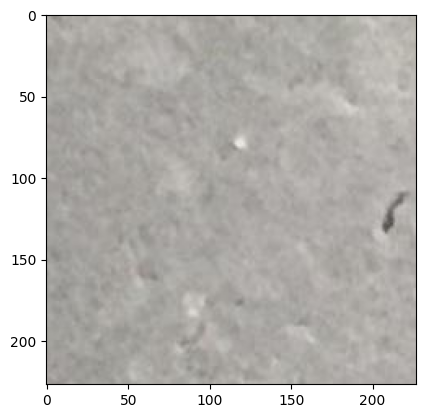

In [10]:
plt.imshow(image_data)

# Data Preparation

In [11]:
dataset_dir = "/kaggle/input/surface-crack-detection"

In [12]:
#defining the data generator
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator()

In [13]:
image_generator = data_generator.flow_from_directory(
    dataset_dir, #the main directory of the dataset
    batch_size=4,
    class_mode='categorical',
    seed = 24
        
)

Found 40000 images belonging to 2 classes.


In [14]:
#Custom Image Data Generator

data_generator = ImageDataGenerator()

In [15]:
image_generator=data_generator.flow_from_directory(
    dataset_dir,
    batch_size=4,
    class_mode='categorical',
    seed=24
)

Found 40000 images belonging to 2 classes.


In [16]:
# Retrieve the first batch of images and labels
first_batch = next(image_generator)

# Check the contents of the batch
images, labels = first_batch  # Unpack the batch into images and labels

# Print shapes to verify
print("Images shape:", images.shape)  # Should be (batch_size, height, width, channels)
print("Labels shape:", labels.shape)  # Should be (batch_size, num_classes) for 'categorical' mode

Images shape: (4, 256, 256, 3)
Labels shape: (4, 2)


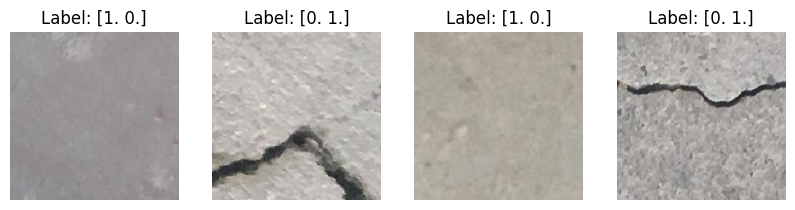

In [17]:
import matplotlib.pyplot as plt

# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(10, 10))  # Adjust figsize as needed
for i in range(4):  # Since batch_size is 4
    axes[i].imshow(images[i].astype('uint8'))  # Convert to uint8 for displaying
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f'Label: {labels[i]}')  # Show the label

plt.show()

In [18]:
# how many images of each class are there in the 4th batch for ex?
# Skip the first three batches
for _ in range(3):
    next(image_generator)

# Retrieve the fourth batch
fourth_batch = next(image_generator)
images, labels = fourth_batch  # Unpack the batch into images and labels

# Count the number of images for each class
if image_generator.class_mode == 'categorical':
    # For one-hot encoded labels, use argmax to get class indices
    class_indices = labels.argmax(axis=1)
else:
    # For other class modes (e.g., 'binary' or 'sparse'), use the labels directly
    class_indices = labels

# Count occurrences of each class
from collections import Counter
class_counts = Counter(class_indices)

# Print the results
print("Number of images from each class in the fourth batch:")
for class_index, count in class_counts.items():
    class_name = list(image_generator.class_indices.keys())[list(image_generator.class_indices.values()).index(class_index)]
    print(f"Class '{class_name}' (index {class_index}): {count} images")


Number of images from each class in the fourth batch:
Class 'Positive' (index 1): 2 images
Class 'Negative' (index 0): 2 images


# Classifier

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [20]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [21]:
#Define global constants
num_classes = 2
image_resize = 224
batch_training = 100
batch_validation = 100

In [22]:
data_generator=ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [27]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
negative_dir = "/kaggle/input/surface-crack-detection/Negative"
positive_dir = "/kaggle/input/surface-crack-detection/Positive"
output_dir = "/kaggle/working/surface-crack-detection"  # Output directory for train/val splits

# Create train and validation directories
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

os.makedirs(os.path.join(train_dir, "positive"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "negative"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "positive"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "negative"), exist_ok=True)

# List all images in positive and negative folders
positive_images = [os.path.join(positive_dir, img) for img in os.listdir(positive_dir)]
negative_images = [os.path.join(negative_dir, img) for img in os.listdir(negative_dir)]

# Split into train and validation sets (75% train, 25% validation)
positive_train, positive_val = train_test_split(positive_images, test_size=0.25, random_state=42)
negative_train, negative_val = train_test_split(negative_images, test_size=0.25, random_state=42)

# Function to copy images to train/val directories
def copy_images(image_list, destination):
    for img_path in image_list:
        shutil.copy(img_path, destination)

# Copy positive images
copy_images(positive_train, os.path.join(train_dir, "positive"))
copy_images(positive_val, os.path.join(val_dir, "positive"))

# Copy negative images
copy_images(negative_train, os.path.join(train_dir, "negative"))
copy_images(negative_val, os.path.join(val_dir, "negative"))

print("Dataset split into train and validation sets successfully!")
print(f"Train set: {len(positive_train) + len(negative_train)} images")
print(f"Validation set: {len(positive_val) + len(negative_val)} images")

Dataset split into train and validation sets successfully!
Train set: 30000 images
Validation set: 10000 images


In [30]:
train_generator=data_generator.flow_from_directory(
    '/kaggle/working/surface-crack-detection/train',
    target_size=(image_resize,image_resize),
    batch_size=batch_training,
    class_mode='categorical'
)

Found 30000 images belonging to 2 classes.


In [31]:
validation_generator=data_generator.flow_from_directory(
    '/kaggle/working/surface-crack-detection/val',
    target_size=(image_resize,image_resize),
    batch_size=batch_training,
    class_mode='categorical'
)

Found 10000 images belonging to 2 classes.


# Build the Model!

In [32]:
model = Sequential()

In [33]:
model.add(
    ResNet50(
        include_top=False,
        pooling='avg',
        weights='imagenet'
    )
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [34]:
#Adding the output layer as the Dense Layer having 2 nodes and using Softmax activation
model.add(
    Dense(
        num_classes,
        activation='softmax'
    )
)

In [35]:
#Look at the layers of the model
model.layers

[<Functional name=resnet50, built=True>, <Dense name=dense, built=True>]

In [36]:
#Stop the training of the layers of the ResNet model 
model.layers[0].trainable=False

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [39]:
#Compile the model using Adam Optimizer
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    
)

In [40]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 2

In [43]:
fit_history=model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1
)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 146s 423ms/step - accuracy: 0.9650 - loss: 0.0787 - val_accuracy: 0.9977 - val_loss: 0.0086
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [44]:
model.save('classifier_resnet_model.h5')

In [45]:
from tensorflow.keras.models import load_model

In [47]:
model = load_model('/kaggle/working/classifier_resnet_model.h5')

In [48]:
#Image Data Generator for the test set
test_dir = '/kaggle/working/surface-crack-detection/val'
test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_resize,image_resize),
    batch_size=batch_training,
    class_mode='categorical'
)

Found 10000 images belonging to 2 classes.


In [49]:
# Evaluate the model on the test data
results = model.evaluate(test_generator)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 316ms/step - accuracy: 0.9609 - loss: 0.0978
Test Loss: 0.09691722691059113
Test Accuracy: 0.9617000222206116
